In [ ]:
# Fix memory issue

In [1]:
%matplotlib inline
import holoviews as hv
hv.notebook_extension()
import sympy.interactive
sympy.interactive.init_printing('mathjax')

In [2]:
try:
    # If this can be imported, it assumes you are on the TU Delft network with access to cluster
    from hpc05 import HPC05Client as Client
    import os
    os.environ['SSH_AUTH_SOCK'] = os.path.join(os.path.expanduser('~'), 'ssh-agent.socket')
    client = Client()
    print("Connected to hpc05")
except ImportError:
    from ipyparallel import Client
    client = Client(profile='python3')
    print("Connected to local engines")

Connected to hpc05


In [3]:
# from ipyparallel import Client
# client = Client(profile='python3')
dview = client[:]
lview = client.load_balanced_view()
len(dview)

In [8]:
%%px --local

import kwant
from kwant.digest import uniform
from types import SimpleNamespace
import sympy
from sympy.physics.quantum import TensorProduct as kr
import numpy as np
from scipy.constants import hbar, m_e, eV, physical_constants
from discretizer import Discretizer, momentum_operators
import scipy.optimize
from itertools import product
from copy import copy
import subprocess
import types
import os.path
import deepdish as dd
import matplotlib.pyplot as plt
from operator import xor

k_B = physical_constants['Boltzmann constant in eV/K'][0] * 1000
sx, sy, sz = [sympy.physics.matrices.msigma(i) for i in range(1, 4)]
s0 = sympy.eye(2)
s0 = sympy.eye(2)
s0sz = np.kron(s0, sz)
s0s0 = np.kron(s0, s0)

# Parameters taken from arXiv:1204.2792
# All constant parameters, mostly fundamental constants, in a SimpleNamespace.
constants = SimpleNamespace(
    m=0.015 * m_e,  # effective mass in kg
    g=50,  # Lande factor
    hbar=hbar,
    m_e=m_e,
    e=eV,
    eV=eV,
    meV=eV * 1e-3)

constants.t = (constants.hbar ** 2 / (2 * constants.m)) * (1e18 / constants.meV)  # meV * nm^2
constants.mu_B = physical_constants['Bohr magneton'][0] / constants.meV

class SimpleNamespace(SimpleNamespace):
    def update(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

def make_params(alpha=20,
                B_x=0,
                B_y=0,
                B_z=0,
                Delta=0.25,
                mu=0,
                orbital=True,
                t=constants.t,
                g=constants.g,
                mu_B=constants.mu_B,
                V=lambda x,y,z: 0,
                **kwargs):
    """Function that creates a namespace with parameters.

    Parameters:
    -----------
    alpha : float
        Spin-orbit coupling strength in units of meV*nm.
    B_x, B_y, B_z : float
        The magnetic field strength in the x, y and z direction in units of Tesla.
    Delta : float
        The superconducting gap in units of meV.
    mu : float
        The chemical potential in units of meV.
    orbital : bool
        Switches the orbital effects on and off.
    t : float
        Hopping parameter in meV * nm^2.
    g : float
        Lande g factor.
    mu_B : float
        Bohr magneton in meV/K.
    V : function
        Function of spatial coordinates (x, y, z) which is added to mu.

    Returns:
    --------
    p : SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    """
    p = SimpleNamespace(t=t,
                        g=g,
                        mu_B=mu_B,
                        alpha=alpha,
                        B_x=B_x,
                        B_y=B_y,
                        B_z=B_z,
                        Delta=Delta,
                        mu=mu,
                        orbital=orbital,
                        V=V,
                        **kwargs)
    return p


def cylinder_sector(r1, r2=0, L=1, L0=0, phi=360, angle=0, a=10):
    """Returns the shape function and start coords.
    
    Parameters:
    -----------
    r1 : int
        Inner radius in nm.
    r2 : int
        Outer radius in nm.
    L : int
        Length of wire from L0 in nm, -1 if infinite in x-direction.
    L0 : int
        Start position in x.
    phi : int
        Coverage angle in degrees.
    angle : int
        Angle of tilting from top in degrees.
    a : int
        Discretization constant in nm.
    
    Returns:
    --------
    (shape_func, *(start_coords))
    """
    phi *= np.pi / 360
    angle *= np.pi / 180
    r1sq, r2sq = r1 ** 2, r2 ** 2
    def sector(pos):
        x, y, z = pos
        n = (y + 1j * z) * np.exp(1j * angle)
        y, z = n.real, n.imag
        rsq = y ** 2 + z ** 2
        
        shape_yz = r2sq <= rsq < r1sq and z >= np.cos(phi) * np.sqrt(rsq)
        return (shape_yz and L0 <= x < L) if L > 0 else shape_yz
    r_mid = (r1 + r2) / 2
    return sector, (L - a, r_mid * np.sin(angle), r_mid * np.cos(angle))


def discretized_hamiltonian(a=10, spin=True, holes=True):
    k_x, k_y, k_z = momentum_operators
    t, B_x, B_y, B_z, mu_B, Delta, mu, alpha, g, V = sympy.symbols('t B_x B_y B_z mu_B Delta mu alpha g V', real=True)
    t_interface = sympy.symbols('t_interface', real=True)
    k = sympy.sqrt(k_x**2+k_y**2+k_z**2)
    if spin and holes:
        ham = ((t * k**2 - mu - V) * kr(s0, sz) +
               alpha * (k_y * kr(sx, sz) - k_x * kr(sy, sz)) +
               0.5 * g * mu_B * (B_x * kr(sx, s0) + B_y * kr(sy, s0) + B_z * kr(sz, s0)) +
               Delta * kr(s0, sx))
    elif not spin and holes:
        ham = ((t * k**2 - mu - V) * s0 +
               alpha * (k_y * sx - k_x * sy) +
               0.5 * g * mu_B * (B_x * sx + B_y * sy + B_z * sz) +
               Delta * s0)
    elif spin and not holes:
        ham = ((t * k**2 - mu - V) * sz +
               alpha * (k_y * sz - k_x * sz) +
               0.5 * g * mu_B * (B_x * s0 + B_y * s0 + B_z * s0) +
               Delta * sx)
    args = dict(space_dependent={'V'}, lattice_constant=a, discrete_coordinates={'x', 'y', 'z'})
    tb_normal = Discretizer(ham.subs(Delta, 0), **args)
    tb_sc = Discretizer(ham.subs([(g, 0), (alpha, 0)]), **args)
    tb_interface = Discretizer(ham.subs(t, t_interface), **args)
    return tb_normal, tb_sc, tb_interface


def hoppingkind_in_shape(hop, shape, syst):
    """Returns an HoppingKind iterator for hoppings in shape."""
    def in_shape(site1, site2, shape):
        return shape[0](site1.pos) and shape[0](site2.pos)
    hoppingkind = kwant.HoppingKind(hop.delta, hop.family_a)(syst)
    return ((i, j) for (i, j) in hoppingkind if in_shape(i, j, shape))


def hoppingkind_at_interface(hop, shape1, shape2, syst):
    """Returns an HoppingKind iterator for hoppings at an interface between
       shape1 and shape2."""
    def at_interface(site1, site2, shape1, shape2):
        return ((shape1[0](site1.pos) and shape2[0](site2.pos)) or 
                (shape2[0](site1.pos) and shape1[0](site2.pos)))
    hoppingkind = kwant.HoppingKind(hop.delta, hop.family_a)(syst)
    return ((i, j) for (i, j) in hoppingkind if at_interface(i, j, shape1, shape2))


def peierls(func, ind, a, c=constants):
    """Applies Peierls phase to the hoppings functions.
    
    Parameters:
    -----------
    func : function
        Hopping function in certain direction.
    ind : int
        Index of xzy direction, corresponding to 0, 1, 2.
    a : int
        Lattice constant in nm.
    c : SimpleNamespace object
        Namespace object that contains fundamental constants.
    
    Returns:
    --------
    with_phase : function
        Hopping function that contains the Peierls phase if p.orbital
        is True.
    """
    def phase(s1, s2, p):
        x, y, z = s1.pos
        A_site = [p.B_y * z - p.B_z * y, 0, p.B_x * y][ind]
        A_site *= a * 1e-18 * c.eV / c.hbar
        return np.exp(-1j * A_site)

    def with_phase(s1, s2, p):
        hop = func(s1, s2, p).astype('complex128')
        phi = phase(s1, s2, p)
        if p.orbital:
            if hop.shape[0] == 2:
                hop *= phi
            elif hop.shape[0] == 4:
                hop *= np.array([phi, phi.conj(), phi, phi.conj()], dtype='complex128')
        return hop

    return with_phase

def make_3d_wire(a, L, r1, r2, phi, angle, L_sc, disorder,
                 with_vlead, with_leads, with_shell, spin, holes):
    """Creates a cylindrical 3D wire partially covered with a superconducting (SC) shell, 
    but without superconductor in the scattering region of length L.
    
    Default arguments:
    ------------------
    (a=10, L=50, r1=50, r2=70, phi=135, angle=0, disorder=False, 
     with_vlead=True, with_leads=True, L_sc=10, with_shell=True,
     spin=True, holes=True)
    Note: we are not using default parameter because I save them in a dictionary, to
    save to file.
    
    Parameters:
    -----------
    a : int
        Discretization constant in nm.
    L : int
        Length of wire (the scattering part without SC shell.) Should be bigger
        than 4 unit cells (4*a) to have the vleads in a region without a SC shell.
    r1 : int
        Radius of normal part of wire in nm.
    r2 : int
        Radius of superconductor in nm.
    phi : int
        Coverage angle of superconductor in degrees.
    angle : int
        Angle of tilting of superconductor from top in degrees.    
    disorder : bool
        When True, syst requires 'disorder' and 'salt' aguments.
    with_vlead : bool
        If True a SelfEnergyLead with zero energy is added to a slice of the system.
    with_leads : bool
        If True it appends infinite leads with superconducting shell.
    L_sc : int
        Number of unit cells that has a superconducting shell. If the system has
        infinite leads, set L_sc=a.
    with_shell : bool
        Adds shell the the correct areas. If False no SC shell is added and only
        a cylindrical wire will be created.

    Returns:
    --------
    syst : kwant.builder.FiniteSystem
        The finilized system.
    hopping : function
        Function that returns the hopping matrix between the two cross sections
        of where the SelfEnergyLead is attached.
    """
    assert L_sc % a == 0
    assert L % a == 0
    
    tb_normal, tb_sc, tb_interface = discretized_hamiltonian(a, spin, holes)
    lat = tb_normal.lattice
    syst = kwant.Builder()
    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)))
    
    # The parts with a SC shell are not counted in the length L, so it's modified as:
    L += 2*L_sc

    # Wire scattering region shapes
    shape_normal = cylinder_sector(r1=r1, angle=angle, L=L, a=a)
    # Superconductor slice in the beginning of the scattering region of L_sc unit cells
    shape_sc_start = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L=L_sc, a=a)
    # Superconductor slice in the end of the scattering region of L_sc unit cells
    shape_sc_end = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L0=L-L_sc, L=L, a=a)
    
    # Lead shapes
    shape_sc_lead = cylinder_sector(r1=r2, r2=r1, phi=phi, angle=angle, L=-1, a=a)
    shape_normal_lead = cylinder_sector(r1=r1, angle=angle, L=-1, a=a)
    
    def onsite_dis(site, p):
        identity = np.eye(4) if spin and holes else np.eye(2)
        return p.disorder * (uniform(repr(site), repr(p.salt)) - 0.5) * identity
    
    # Add onsite terms in the scattering region
    syst[lat.shape(*shape_normal)] = lambda s, p: tb_normal.onsite(s, p) + (onsite_dis(s, p) if disorder else 0)
    if with_shell:
        syst[lat.shape(*shape_sc_start)] = tb_sc.onsite
        syst[lat.shape(*shape_sc_end)] = tb_sc.onsite

    # Add onsite terms in the infinite lead
    lead[lat.shape(*shape_normal_lead)] = tb_normal.onsite
    if with_shell:
        lead[lat.shape(*shape_sc_lead)] = tb_sc.onsite

    for hop, func in tb_normal.hoppings.items():
        # Add hoppings in normal parts of wire and lead with Peierls substitution
        ind = np.argmax(hop.delta) # Index of direction of hopping
        syst[hoppingkind_in_shape(hop, shape_normal, syst)] = peierls(func, ind, a)
        lead[hoppingkind_in_shape(hop, shape_normal_lead, lead)] = peierls(func, ind, a)

    if with_shell:
        for hop, func in tb_sc.hoppings.items():
            # Add hoppings in superconducting parts of wire and lead
            syst[hoppingkind_in_shape(hop, shape_sc_start, syst)] = func
            syst[hoppingkind_in_shape(hop, shape_sc_end, syst)] = func
            lead[hoppingkind_in_shape(hop, shape_sc_lead, lead)] = func

        for hop, func in tb_interface.hoppings.items():
            # Add hoppings at the interface of superconducting parts and normal parts of wire and lead
            syst[hoppingkind_at_interface(hop, shape_sc_start, shape_normal, syst)] = func
            syst[hoppingkind_at_interface(hop, shape_sc_end, shape_normal, syst)] = func
            lead[hoppingkind_at_interface(hop, shape_sc_lead, shape_normal_lead, lead)] = func
        
    def cut(x_cut):
        """Return the sites at a cross section at x_cut."""
        sites = [lat(x, y, z) for x, y, z in (i.tag for i in syst.sites()) if x == x_cut]
        return sorted(sites, key=lambda s: s.pos[2] * 10000 + s.pos[1])
    
    # Define left and right cut in wire in the middle of the wire, a region without superconducting shell.
    l_cut = cut(L // (2*a) - 1)
    r_cut = cut(L // (2*a))
    num_orbs = 4
    dim = num_orbs * (len(l_cut) + len(r_cut))
    vlead = kwant.builder.SelfEnergyLead(lambda energy, args: np.zeros((dim, dim)), r_cut + l_cut)
        
    if with_vlead:
        syst.leads.append(vlead)
    if with_leads:
        syst.attach_lead(lead)
        syst.attach_lead(lead.reversed())

    syst = syst.finalized()

    r_cut_sites = [syst.sites.index(site) for site in r_cut]
    l_cut_sites = [syst.sites.index(site) for site in l_cut]
    
    def hopping(syst, args=()):
        """Function that returns the hopping matrix of the electrons
        between the two cross sections."""
        return syst.hamiltonian_submatrix(args=args,
                                          to_sites=l_cut_sites,
                                          from_sites=r_cut_sites)[::2, ::2]
    return syst, hopping


def matsubara_frequency(T, n):
    return (2*n + 1) * np.pi * k_B * T * 1j


def null_H(syst, p, T, n):
    en = matsubara_frequency(T, n)
    gf = kwant.greens_function(syst, en, [p], [0], [0], check_hermiticity=False)
    return np.linalg.inv(gf.data[::2, ::2])


def gf_from_H_0(H_0, t):
    H = np.copy(H_0)
    dim = t.shape[0]
    H[:dim, dim:] -= t.T.conj()
    H[dim:, :dim] -= t
    return np.linalg.inv(H)


def current_contrib_from_H_0(T, H_0, H12, phase):
    t = H12 * np.exp(1j * phase) # Maybe take this line outside of the function?
    gf = gf_from_H_0(H_0, t - H12)
    dim = t.shape[0]
    H12G21 = t.T.conj() @ gf[dim:, :dim]
    H21G12 = t @ gf[:dim, dim:]
    return -4 * T * (np.trace(H21G12) - np.trace(H12G21)).imag


def current_at_phase(syst, p, T, phase, tol=1e-2):
    H12 = hopping(syst, [p])
    I = current_contrib_from_H_0(T, null_H(syst, T, n=0), H12, phase)
    error = 1
    n = 1
    while error > tol:
        H_0 = null_H(syst, T, n)
        I_contrib = current_contrib_from_H_0(T, H_0, H12, phase)
        n += 1
        I += I_contrib
        error = np.abs(I_contrib / I)
        if n > 50:
            print('Did not converge in 50 Matsubara frequencies.')
            break
    return I


def I_c(syst, hopping, p, T, tol=1e-2):
    fun = lambda phase: -current_at_phase(syst, p, T, phase, tol)
    opt = scipy.optimize.minimize_scalar(fun, bounds=(-np.pi, np.pi), method='bounded')
    phase = opt['x']
    current = -opt['fun']
    return current, phase


def save_data(fname, p, constants, Bs, tol, wire_params, T, I_cs, phases, **kwargs):
    if os.path.exists(fname):
        return "File already existed"
    
    def SimpleNamespace_save(p):
        """Removes functions from SimpleNamespace."""
        p_new = {key: val for key, val in p.__dict__.items() 
                 if not isinstance(val, types.FunctionType)}
        return SimpleNamespace(**p_new)
    
    def get_git_revision_hash():
        return subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode("utf-8").replace('\n', '')

    data = {'p': SimpleNamespace_save(p),
            'constants': SimpleNamespace_save(constants),
            'B_xs': Bs,
            'tol': tol,
            'wire_params': wire_params,
            'T': T,
            'I_cs': I_cs,
            'phases': phases,
            'git_hash': get_git_revision_hash(), **kwargs}

    dd.io.save(fname, data, compression='blosc')

# Creating some wires as example

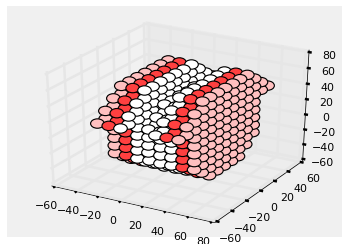

In [5]:
# Create system with infinite leads
wire_params = dict(a=10, L=20, r1=50, r2=70, phi=135, angle=0, holes=True, spin=True,
                   disorder=False, with_vlead=True, with_leads=True, L_sc=10, with_shell=True)
syst, hopping = make_3d_wire(**wire_params)
kwant.plot(syst)

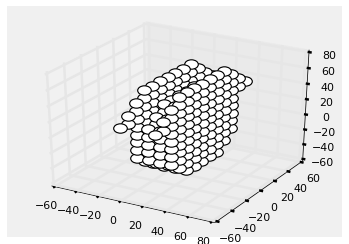

In [6]:
# Create system without leads
wire_params['with_leads'] = False
syst, hopping = make_3d_wire(**wire_params)
kwant.plot(syst)

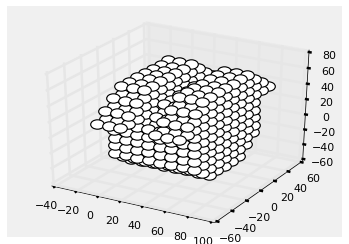

In [7]:
# Create system without leads and bigger SC regions
wire_params['L_sc'] = 30
syst, hopping = make_3d_wire(**wire_params)
kwant.plot(syst)

# $T$ vs $I_c$ with disorder

In [ ]:
%%px --local
p = make_params(Delta=60, alpha=20, mu=15, B_x=0, B_y=0, t_interface=7/8*constants.t, disorder=None, salt=None)
wire_params = dict(a=10, L=400, r1=50, r2=70, phi=135, angle=0, 
                   disorder=True, with_vlead=True, with_leads=False, L_sc=400)
syst, hopping = make_3d_wire(**wire_params)

In [ ]:
Ts = [0.1, 0.5, 1]
salts = range(10)
disorders = [0, 10, 20, 40]
I = lview.map_async(lambda x: I_c(syst, hopping, p.update(salt=x[0], disorder=x[1]), T=x[2], tol=1e-2),
                    product(salts, disorders, Ts))

I.wait_interactive()

Ic = np.array(I.result()).reshape(len(salts), len(disorders), len(Ts), -1)

I_cs, phases = Ic.T

In [ ]:
wire_type = "infinite_leads" if wire_params['with_leads'] else 'leads_{}_nm'.format(wire_params['L_sc'])
save_data('T_vs_Ic__L_{}_nm__mu_{:.0f}_meV__{}.h5'.format(wire_params['L'], p.mu, wire_type), dview['p'][0], constants, None, matsfreqs, wire_params, Ts, I_cs, phases,
          disorders=disorders, salts=salts)

In [13]:
"{:.0f}".format(15.00000)

'15'

# Relative importance of Zeeman, orbital, and spin-orbit

In [ ]:
p = make_params(Delta=60, alpha=20, mu=0, B_x=0, B_y=0, t_interface=7/8*constants.t, disorder=None, salt=None)
wire_params = dict(a=10, L=600, r1=50, r2=70, phi=135, angle=0, disorder=True)
syst, hopping = make_3d_wire(**wire_params)
sorted(np.abs(kwant.physics.Bands(syst.leads[1], args=[p])(k=0)))[:13]

# Mean free path

In [ ]:
%%px --local
def transmission(syst, p):
    smatrix = kwant.smatrix(syst, args=[p])
    return smatrix.transmission(0, 1), smatrix.num_propagating(0)

p = make_params(Delta=0, alpha=20, mu=2a0, B_x=0, B_y=0, B_z=0, disorder=None, salt=None)
wire_params = dict(a=8, L=None, r1=50, r2=70, phi=135, angle=0, disorder=True,
                   with_vlead=False, with_leads=True, L_sc=8, with_shell=False, holes=False, spin=True)

In [ ]:
Ls = np.arange(80, 500, 80)
conductances = []
num_propagating = []
for L in Ls:
    print(L)
    dview.execute('wire_params["L"] = {}'.format(L))
    %px syst, hopping = make_3d_wire(**wire_params)
    salts = range(30)
    disorders = np.arange(0, 150, 10)
    conductance = lview.map_async(lambda x: transmission(syst, p.update(salt=x[0], disorder=x[1])), 
                        product(salts, disorders))
    conductance.wait_interactive()
    conductance = np.array(conductance.result()).reshape(len(salts), len(disorders), -1)
    num_propagating.append(conductance[:, :, 1])
    conductances.append(conductance[:, :, 0])

In [ ]:
save_data('data/mfp_mu-{:0.0f}meV.h5'.format(p.mu), p, constants, 0, None, wire_params, 
          T=None, I_cs=None, phases=None, conductances=conductances, salts=salts,
          disorders=disorders, Ls=Ls, num_propagating=num_propagating)

# Disorder $B_x$ vs $I_c$

In [ ]:
%%px --local
p = make_params(Delta=60, alpha=20, mu=50, B_x=0, B_y=0, t_interface=7/8*constants.t, disorder=None, salt=None)
wire_params = dict(a=8, L=800, r1=50, r2=70, phi=180, angle=0, disorder=True, 
                   with_vlead=True, with_leads=False, L_sc=480, with_shell=True, holes=True, spin=True)
T = 1#60e-3
syst, hopping = make_3d_wire(**wire_params)

In [ ]:
Bs = np.linspace(0, 1, 100)
salts = range(30)
disorders = [0, 1, 2, 5, 10, 20, 30, 40, 50]
I = lview.map_async(lambda x: I_c(syst, hopping, p.update(salt=x[0], disorder=x[1], B_x=x[2]), T, matsfreqs=20), 
                    product(salts, disorders, Bs))

In [ ]:
I.abort(
)

In [ ]:
I.wait_interactive()

Ic = np.array(I.result()).reshape(len(salts), len(disorders), len(Bs), -1)

fname = 'L_{}-matfreqs_{}-a_{}-T_{}_disorder-mu-{}meV_finite_leads2.h5'.format(wire_params['L'], 1, wire_params['a'], T, p.mu)
save_data(fname, p, constants, Bs, 1, wire_params, T, phases=Ic[..., 1], I_cs=Ic[..., 0], disorders=disorders, salts=salts)

# vary $L$, $n$, and $a$ without disorder:

In [ ]:
%px p = make_params(Delta=60, alpha=20, mu=15, B_x=None, t_interface=7/8*constants.t)
p = make_params(Delta=60, alpha=20, mu=15, B_x=None, t_interface=7/8*constants.t)

wire_params = dict(a=None, L=None, r1=50, r2=70, phi=135, angle=0, 
                   disorder=False, with_vlead=True, with_leads=False, L_sc=400,
                  with_shell=True, holes=True, spin=True)
Bs = np.linspace(0, 2, 100)
for wire_params['a'] in [8]:
    for wire_params['L'] in [80, 160, 320, 400, 800]:
        fname = 'L_{}-a_{}.h5'.format(wire_params['L'], wire_params['a'])
        if not os.path.isfile(fname):
            Ts = [60e-3, 0.1, 1]
            matsfreqs = [1, 2, 4, 10, 20, 30]
            dview['wire_params'] = wire_params
            %px syst, hopping = make_3d_wire(**wire_params)
            I = lview.map_async(lambda x: I_c(syst, hopping, p.update(B_x=x[0]), T=x[1], matsfreqs=x[2]),
                                product(Bs, Ts, matsfreqs))
            I.wait_interactive()
            I_cs, phases = np.array(I.result()).reshape(len(Bs), len(Ts), len(matsfreqs), -1).T
            save_data(fname, p, constants, Bs, matsfreqs, wire_params, T=Ts, I_cs=I_cs, phases=phases)

# Induced gap

In [ ]:
%%px --local
# Create system with infinite leads
wire_params = dict(a=8, L=800, r1=50, r2=70, phi=135, angle=0, 
                   disorder=False, with_vlead=True, with_leads=True, L_sc=400)
syst, hopping = make_3d_wire(**wire_params)
lead = syst.leads[1]

p = make_params(t_interface=7/8*constants.t)

def evs(lead, p):
    h0 = lead.cell_hamiltonian(args=[p])
    t0 = lead.inter_cell_hopping(args=[p])
    ham = h0 + t0 + t0.conj().T
    ev = np.linalg.eigvalsh(ham)
    return np.abs(ev).min()

In [ ]:
mus = np.linspace(2, 20, 50)
deltas = np.linspace(0, 100, 50)
vals = list(product(deltas, mus))
dview.scatter('vals', vals, block=True)
%px res = [evs(lead, p) for p.Delta, p.mu in vals]
res = np.reshape(dview.gather('res', block=True), (len(deltas), len(mus)))
print("Max gap is {} meV".format(max(res.min(axis=1))))

In [ ]:
hv.Curve((deltas, res.min(axis=1)), kdims=['$\Delta$'], vdims=['$E_{gap}$'], label="$E_{gap}$ over range of $\Delta$'s")

In [ ]:
Delta_ind = {delta: hv.Path((mus, evs), kdims=['$\mu$', ('E_gap', '$E_{gap}$')]) 
      for evs, delta in zip(res, deltas)}

hm = hv.HoloMap(Delta_ind, kdims=['$\Delta$'])
(hm.select(E_gap=(0.2, 0.3)) * hv.HLine(0.25))